In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline
#%matplotlib widget

In [2]:
import numpy as np
import umap
from sklearn.decomposition import PCA
import tqdm

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('bioAI.mplstyle')

import sys
sys.path.append('../') if '../' not in sys.path else None 
from methods import *
from plotting_functions import *

In [3]:
nx,ny = 3,3 # board size
res = 64

# initialize board
xx, yy = np.meshgrid(
    np.linspace(-nx/2, nx/2, res),
    np.linspace(-ny/2, ny/2, res),
)
board = np.stack([xx, yy], axis=-1)

# initialize grid module
T = 1
f = 1/T
orientation_offset = 0
center = np.zeros(2)
#board += center

#gridmodule = GridModule(center,orientation_offset,f,non_negative=False,add=True)
gridmodule = SquareGridModule(center,orientation_offset,f,non_negative=False,add=True)

In [4]:
#phases = gridmodule.inner_hexagon.sample(3,seed=3)
phases = gridmodule.inner_square.sample(3,seed=3)
gridmodule.init_module(phases)
ratemaps = gridmodule(board)
#masked_ratemaps = gridmodule.masked_ratemaps(board)
phases.shape, ratemaps.shape

((3, 2), (3, 64, 64))

(<Figure size 300x300 with 1 Axes>, <AxesSubplot:>)

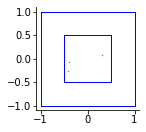

In [5]:
gridmodule.plot(figsize=(2,2))

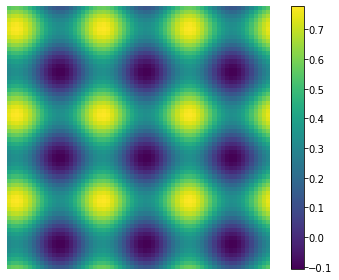

In [7]:
plt.imshow(ratemaps[0])
plt.axis('off')
plt.colorbar()

## Find roots (optimise) of spatial position, given activity

In [8]:
def loss_fn_wrapper(activity, gridmodule):
    # activity: (ncells,)
    def loss_fn(loc):
        return np.sum((gridmodule(loc) - activity)**2)
    return loss_fn

In [9]:
# example decoding
import scipy
solution = np.array([0.5,0.5])
loss_fn = loss_fn_wrapper(gridmodule(solution), gridmodule)
scipy.optimize.minimize(loss_fn,np.array([0.3,0.3]))

      fun: 3.167528709791339e-12
 hess_inv: array([[ 0.58812258, -0.50169553],
       [-0.50169553,  0.6154876 ]])
      jac: array([-9.19856566e-07,  2.41425016e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 8
     njev: 13
   status: 0
  success: True
        x: array([1.49999823, 0.50000195])

In [10]:
def decode_via_optimisation(activity,gridmodule,x0):
    """
    params:
        activity: (ncells,) grid cells ensemble activity that we want to decode to space 
        gridmodule: Gridmodule object
        x0: initial spatial coordiante to start with (2,)
    """
    loss_fn = loss_fn_wrapper(activity, gridmodule)
    return scipy.optimize.minimize(loss_fn,x0)

In [53]:
label_pos = np.random.uniform(-T/2, T/2, size=2)
label_pos = np.array([0.29187213, -0.18899286])
activity = gridmodule(label_pos)

decoded_pos = np.zeros_like(board)
for i in tqdm.trange(res):
    for j in range(res):
        decoded_pos[i,j] = decode_via_optimisation(activity,gridmodule,board[i,j]).x

100%|█████████████████████████████████████████████████████████████████████████████| 64/64 [00:10<00:00,  6.00it/s]


In [54]:
#heuristic_origin = np.mean(phases,axis=0)
#heuristic_origin -= 0.5/T
#decoded_modulo_pos = (decoded_pos - heuristic_origin) % T
decoded_modulo_pos = (decoded_pos + 0.5*T) % T
decoded_modulo_pos -= 0.5*T

In [67]:
np.unique(np.around(decoded_modulo_pos,decimals=4).reshape(-1,2),axis=0)

array([[-0.4727,  0.2443],
       [ 0.2919, -0.189 ]])

In [55]:
#-0.24187328,  0.075241 leads to 0.29187213, -0.18899286
# 0.29187213, -0.18899286 leads to -0.47272336,  0.24432241
# => non-symmetrical solutions?

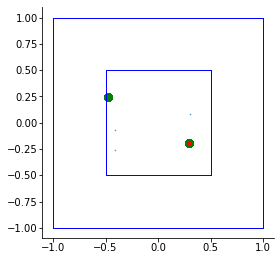

In [56]:
fig, ax = gridmodule.plot(figsize=(4,4))
ax.scatter(*decoded_modulo_pos.reshape(-1,2).T, s=50, color='green')#, label='pred')
ax.scatter(*label_pos, s=20, color='red')#, label='true')
#ax.legend()
#ax.axis('off')